# CLIP + SAM

In [17]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [18]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="c:\\Users\\Riley\\Desktop\\sam_vit_h_4b8939.pth"))

In [ ]:
image_path = "c:\\Users\\Riley\\Desktop\\Portal\\Code\\Images\\0000_C0000578F.jpg"

In [20]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [21]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [22]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [23]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [24]:
#Make sure it works
import clip
print(dir(clip))

#check versions
import torch
print(torch.__version__)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']
2.4.1+cu118


In [25]:
# Load CLIP
import clip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [26]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [27]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

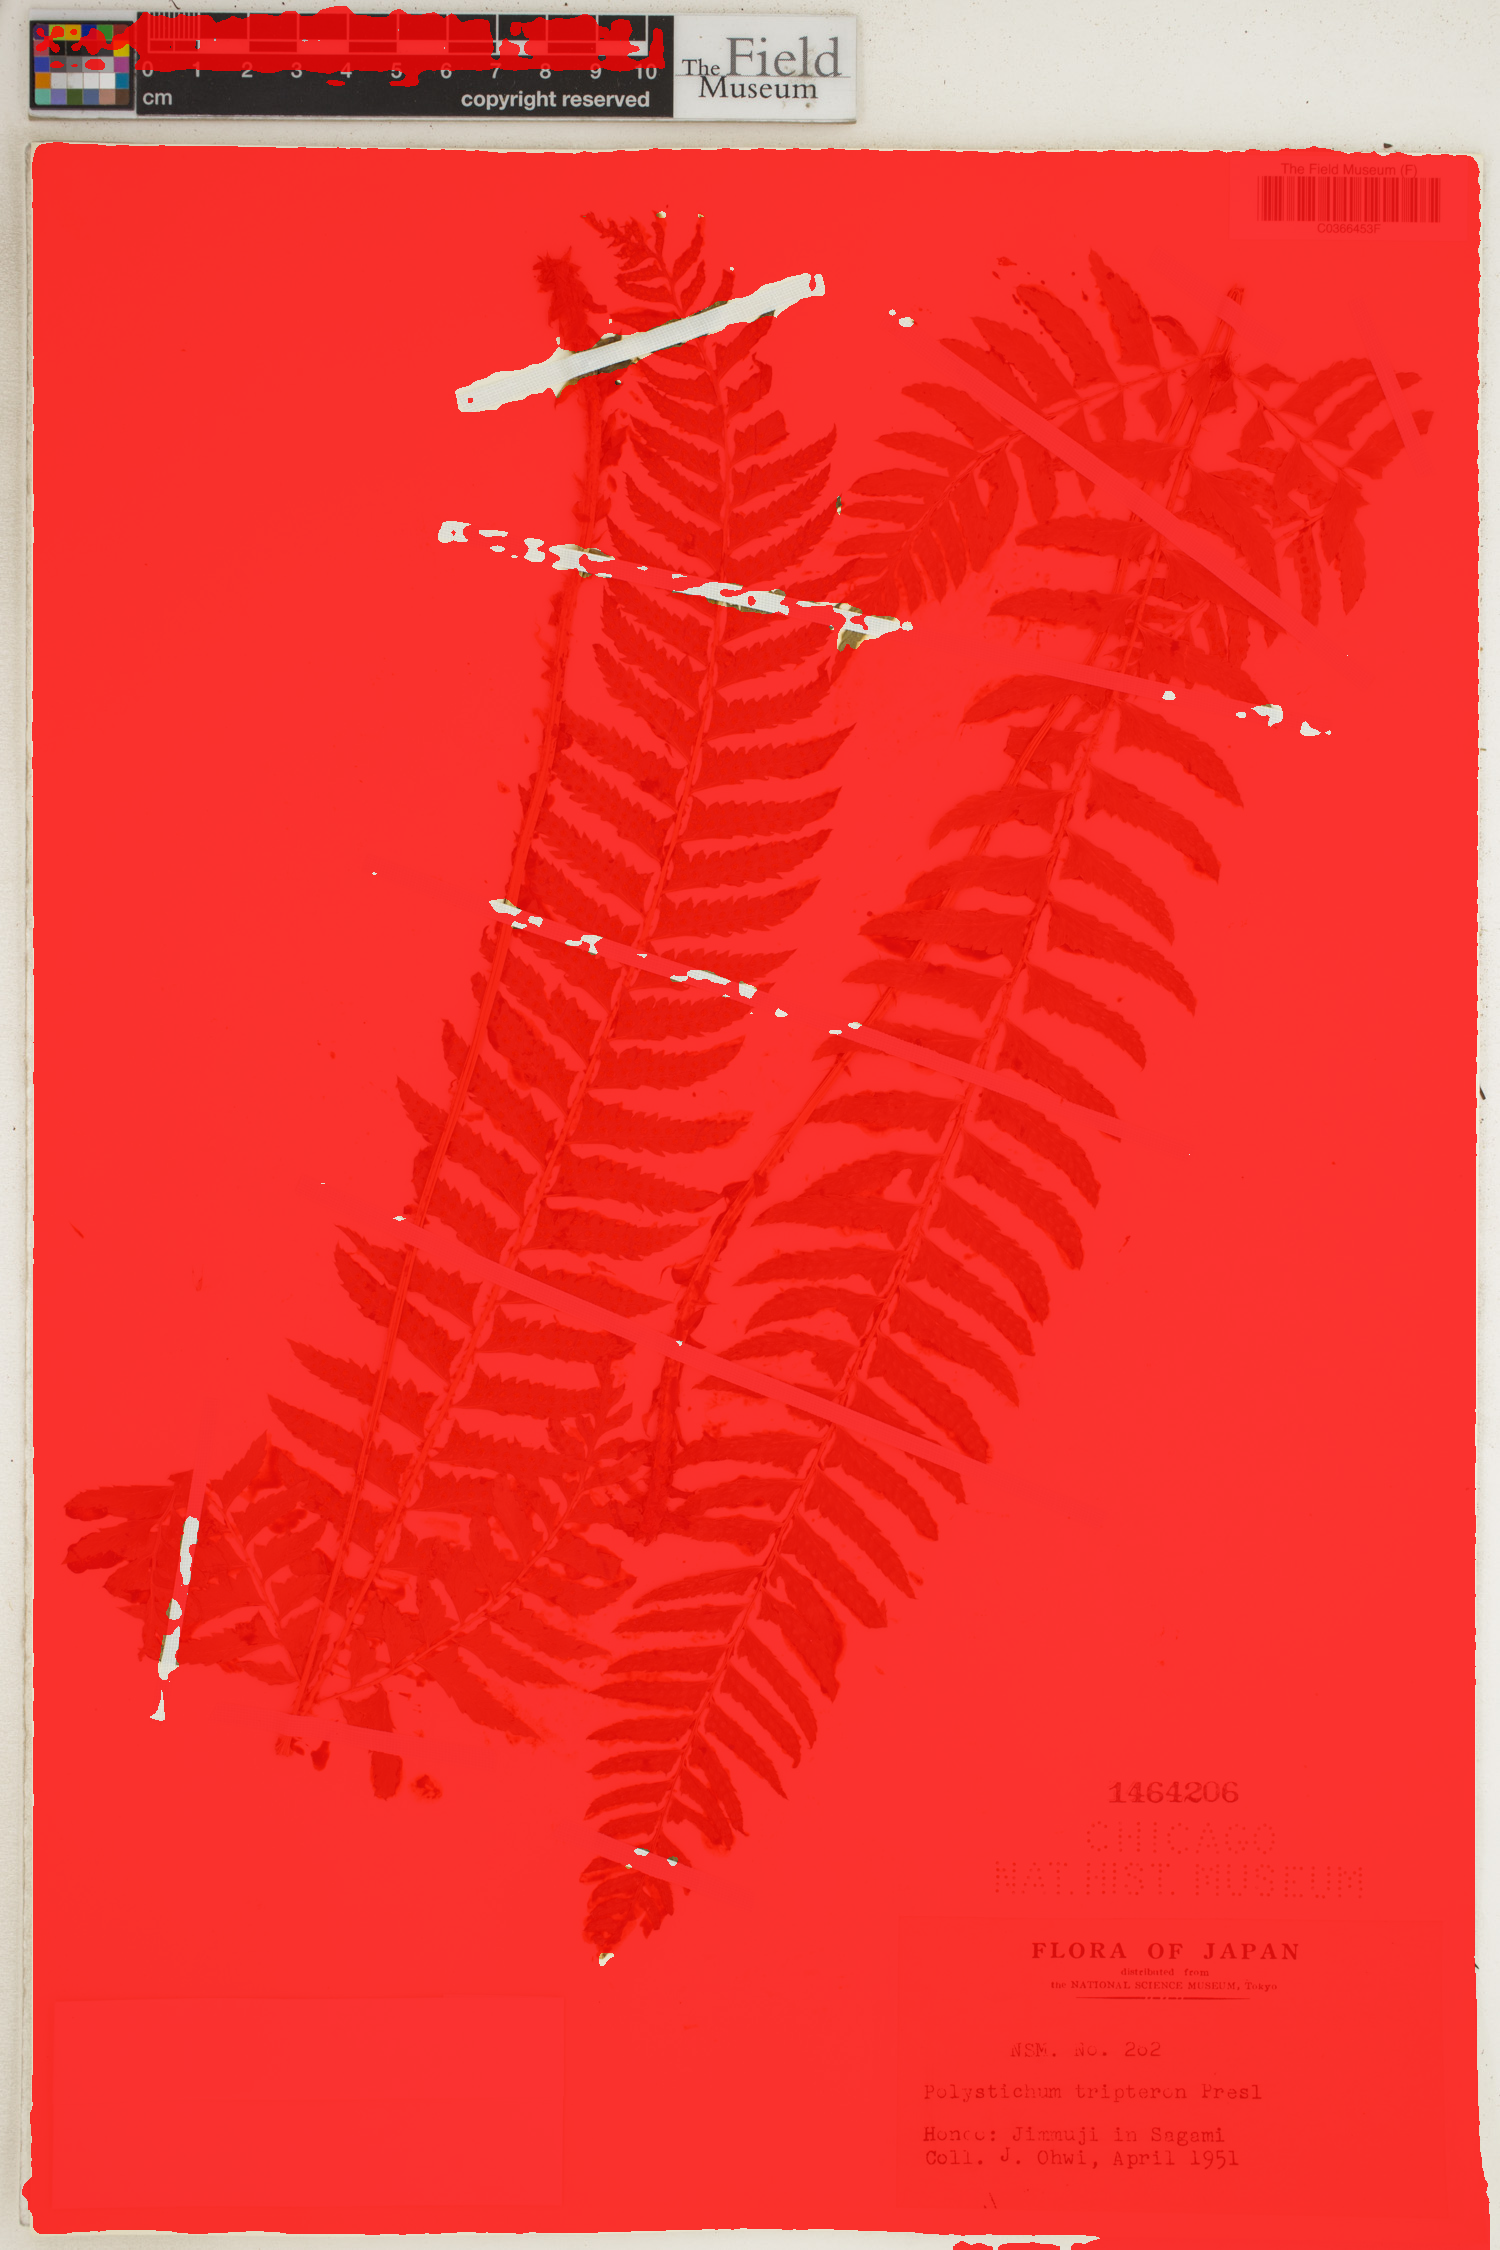

In [28]:

prompts = [
    "words", 
    "text",  
    "numbers",  
    "labels",            
    "names of people",
    "label text",
    "botanical annotations", 
    "locality information",
    "printed and handwritten text"
    "Country, city, and date",
    "record Numbers",
    #"small regions of text and labels",
    "Field Museum of Natural History",
    #"Barcode and QR code"
              
]

# prompts = [
#     "label text, botanical annotations, locality information"
# ]

# Initialize an empty list for all segmentation masks
segmentation_masks = []

# Loop over each prompt and retrieve masks that meet the threshold
for prompt in prompts:
    scores = retriev(cropped_boxes, prompt)  # Retrieve scores for esach prompt
    #print(scores)
    indices = get_indices_of_values_above_threshold(scores, 0.45)

    # Collect masks for each prompt's detected regions
    for seg_idx in indices:
        segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
        segmentation_masks.append(segmentation_mask_image)

# Prepare overlay on the original image
original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

# Draw each segmentation mask on the overlay image
draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

# Composite the overlay on the original image and display the result
result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)

result_image
